### Notebook layout:

Preprocess data

Vanilla RNN

Word Embeddings

LSTM

GRU

Bidirectional LSTM

Model Evaluation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential,Input,Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### 1. Preprocess data

In [ ]:
import nltk
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('universal_tagset')

# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [ ]:
tagged_sentences[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

###  Divide data in words (X) and tags (Y)

Since this is a many-to-many problem, each data point will be a different sentence of the corpora.

Each data point will have multiple words in the input sequence. This is what we will refer to as X.

Each word will have its correpsonding tag in the output sequence. This what we will refer to as Y.

Sample dataset:

X	Y
Mr. Vinken is chairman of Elsevier	NOUN NOUN VERB NOUN ADP NOUN
We have no useful information	PRON VERB DET ADJ NOUN


In [ ]:
X = [] # store input sequences
Y = [] # store output sequences

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:
        X_sentence.append(entity[0]) # entity[0] contains the word
        Y_sentence.append(entity[1]) # entity[1] contains the tag
    X.append(X_sentence)
    Y.append(Y_sentence)

In [ ]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in Y for word in sentence]))

In [ ]:
print('Total no.of tagged sentenses are %s' %(len(X)))
print('Total no.of tagged sentences: {}'.format(len(X)))
print('Vocabulary size : {}'.format(num_words))
print('Total no.of tags : {}'.format(num_tags))

Total no.of tagged sentenses are 72202
Total no.of tagged sentences: 72202
Vocabulary size : 59448
Total no.of tags : 12


In [ ]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [ ]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print('Length of first input sequence : {}'.format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence : 18
Length of first output sequence : 18


Now we have feed these as inputs to RNN's

We know that the inputs should be numerical

Encode X and Y to integer values

We'll use the Tokenizer() function from Keras library to encode text sequence to integer sequence

In [ ]:
# encode X
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

In [ ]:
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [ ]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [ ]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


### Pad sequences

The next step after encoding the data is to define the sequence lengths. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a hyperparameter.

In [ ]:
lengths = [len(seq) for seq in X_encoded]
print('length of longest sentence : {}'.format(max(lengths)))

length of longest sentence : 271


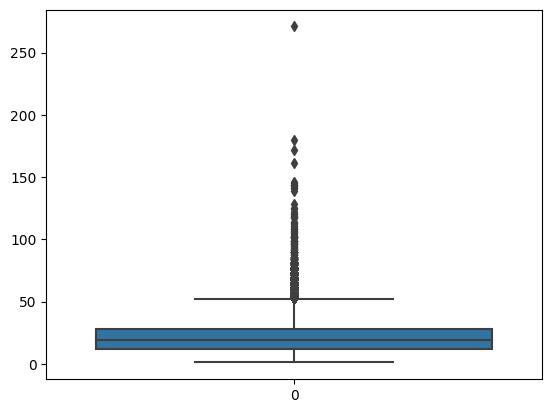

In [ ]:
sns.boxplot(lengths)
plt.show()

In [ ]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function.
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'.
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen = MAX_SEQ_LENGTH, padding='pre', truncating='post' )
Y_padded = pad_sequences(Y_encoded, maxlen = MAX_SEQ_LENGTH, padding='pre', truncating='post')

In [ ]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [ ]:
X, Y = X_padded, Y_padded

### Word embeddings

Currently, each word and each tag is encoded as an integer.

We'll use a more sophisticated technique to represent the input words (X) using what's known as word embeddings.

However, to represent each tag in Y, we'll simply use one-hot encoding scheme since there are only 13 tags in the dataset and the LSTM will have no problems in learning its own representation of these tags.

To use word embeddings, you can go for either of the following models:

word2vec model: https://code.google.com/archive/p/word2vec/
GloVe model : https://nlp.stanford.edu/projects/glove/
We're using the word2vec model for no particular reason. Both of these are very efficient in representing words. You can try both and see which one works better.

Dimensions of a word embedding is: (VOCABULARY_SIZE, EMBEDDING_DIMENSION)

Use word embeddings for input sequences (X)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# word2vec download link (Size ~ 1.5GB): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

import pathlib
path = pathlib.Path('/content/gdrive/My Drive/word-embeddings/GoogleNews-vectors-negative300.bin.gz')

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [ ]:
# assign word vectors from word2vec model
EMBEDDING_SIZE = 300 # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE,EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# print(word2id)
# copy vectors from word2vec model to the words present in corpus

for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
# print embedding dimension
print('Embedding shape: {}'.format(embedding_weights.size))

Embedding shape: 17834700


In [ ]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

**Use one-hot encoding for output sequences (Y)**

In [ ]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [ ]:
print(Y.shape)

(72202, 100, 13)


**Split data in training, validation and tesing sets**

In [ ]:
TEST_SIZE = 0.15
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state = 4)

In [ ]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [ ]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

Shape of X: (#samples, #timesteps, #features)

Shape of Y: (#samples, #timesteps, #features)

![RNN tensor shape](./jupyter resources/rnn_tensor.png)

Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

Uninitialised fixed embeddings

First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.

In [ ]:
# total no.of tags
NUM_CLASSES = Y.shape[2]
print(NUM_CLASSES)

13


In [ ]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text-problems
rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE, # vocabulary size - number of unique words in data
                        output_dim = EMBEDDING_SIZE, # length of vector with which each word is represented
                        input_length = MAX_SEQ_LENGTH, # length of input sequence
                        trainable = False # False - don't update the embeddings
                        ))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, return_sequences=True # True - return whole sequence; False - return single output of the end of the sequence
                        ))

# add time distributed (output at each sequence) layer

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
rnn_model.compile(loss='categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['acc'])

In [ ]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDist  (None, 100, 13)           845       
 ributed)                                                        
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 24205 (94.55 KB)
Non-trainable params: 17834700 (68.03 MB)
_________________________________________________________________


**Fit Model**

In [ ]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation,Y_validation))

Epoch 1/10
408/408 [==============================] - 45s 112ms/step - loss: 0.1220 - acc: 0.9589 - val_loss: 0.1205 - val_acc: 0.9596
Epoch 2/10
408/408 [==============================] - 54s 133ms/step - loss: 0.1199 - acc: 0.9594 - val_loss: 0.1177 - val_acc: 0.9600
Epoch 3/10
408/408 [==============================] - 46s 113ms/step - loss: 0.1181 - acc: 0.9599 - val_loss: 0.1162 - val_acc: 0.9607
Epoch 4/10
408/408 [==============================] - 52s 128ms/step - loss: 0.1165 - acc: 0.9603 - val_loss: 0.1149 - val_acc: 0.9611
Epoch 5/10
408/408 [==============================] - 58s 142ms/step - loss: 0.1151 - acc: 0.9607 - val_loss: 0.1136 - val_acc: 0.9614
Epoch 6/10
408/408 [==============================] - 37s 90ms/step - loss: 0.1138 - acc: 0.9611 - val_loss: 0.1126 - val_acc: 0.9618
Epoch 7/10
408/408 [==============================] - 37s 91ms/step - loss: 0.1125 - acc: 0.9615 - val_loss: 0.1110 - val_acc: 0.9619
Epoch 8/10
408/408 [==============================] - 40s

**Uninitialised Trainable embeddings**

In [ ]:
rnn_model = Sequential()

rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an rnn layer which consists 64 rnn cells
rnn_model.add(SimpleRNN(64,
                        return_sequences=True))

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

**Compile Model**

In [ ]:
rnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [ ]:
# summary
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 17858905 (68.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fit model

rnn_training = rnn_model.fit(X_train,Y_train,batch_size=128, epochs=10, validation_data=(X_validation,Y_validation))

Epoch 1/10
408/408 [==============================] - 106s 255ms/step - loss: 0.2181 - acc: 0.9496 - val_loss: 0.0425 - val_acc: 0.9874
Epoch 2/10
408/408 [==============================] - 62s 153ms/step - loss: 0.0306 - acc: 0.9902 - val_loss: 0.0300 - val_acc: 0.9897
Epoch 3/10
408/408 [==============================] - 47s 115ms/step - loss: 0.0213 - acc: 0.9926 - val_loss: 0.0275 - val_acc: 0.9902
Epoch 4/10
408/408 [==============================] - 50s 121ms/step - loss: 0.0175 - acc: 0.9938 - val_loss: 0.0270 - val_acc: 0.9904
Epoch 5/10
408/408 [==============================] - 47s 116ms/step - loss: 0.0151 - acc: 0.9946 - val_loss: 0.0271 - val_acc: 0.9904
Epoch 6/10
408/408 [==============================] - 46s 113ms/step - loss: 0.0131 - acc: 0.9954 - val_loss: 0.0280 - val_acc: 0.9903
Epoch 7/10
408/408 [==============================] - 45s 110ms/step - loss: 0.0112 - acc: 0.9961 - val_loss: 0.0293 - val_acc: 0.9903
Epoch 8/10
408/408 [==============================] - 

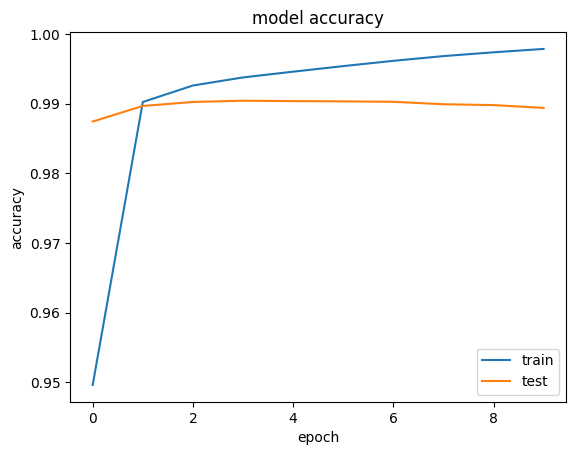

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

**Using pre-trained embedding weights**

In [ ]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
# compile
rnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [ ]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 17858905 (68.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 68s 160ms/step - loss: 0.1753 - acc: 0.9623 - val_loss: 0.0342 - val_acc: 0.9890
Epoch 2/10
408/408 [==============================] - 73s 178ms/step - loss: 0.0263 - acc: 0.9911 - val_loss: 0.0269 - val_acc: 0.9904
Epoch 3/10
408/408 [==============================] - 67s 164ms/step - loss: 0.0197 - acc: 0.9929 - val_loss: 0.0253 - val_acc: 0.9910
Epoch 4/10
408/408 [==============================] - 71s 174ms/step - loss: 0.0168 - acc: 0.9939 - val_loss: 0.0249 - val_acc: 0.9911
Epoch 5/10
408/408 [==============================] - 56s 137ms/step - loss: 0.0148 - acc: 0.9946 - val_loss: 0.0250 - val_acc: 0.9912
Epoch 6/10
408/408 [==============================] - 52s 127ms/step - loss: 0.0131 - acc: 0.9953 - val_loss: 0.0256 - val_acc: 0.9911
Epoch 7/10
408/408 [==============================] - 56s 136ms/step - loss: 0.0116 - acc: 0.9959 - val_loss: 0.0264 - val_acc: 0.9911
Epoch 8/10
408/408 [==============================] - 4

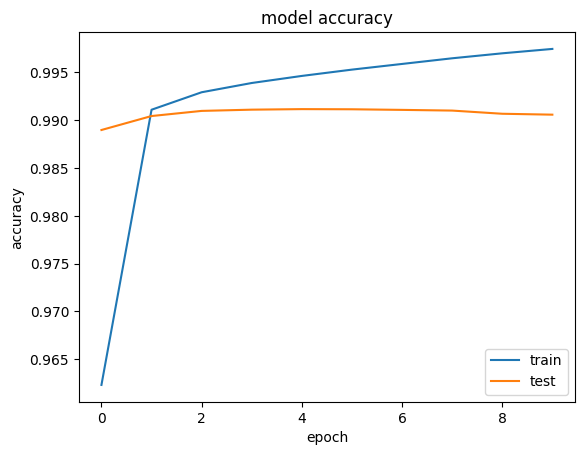

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

2. LSTM

We'll use pre-trained word embeddings in following models and allow them to be updated as well.

In [ ]:
# create model architecture
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True
                         ))

lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES,activation='softmax')))

In [ ]:
# compile
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [ ]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17928985 (68.39 MB)
Trainable params: 17928985 (68.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 34s 76ms/step - loss: 0.3137 - acc: 0.9291 - val_loss: 0.0483 - val_acc: 0.9869
Epoch 2/10
408/408 [==============================] - 12s 28ms/step - loss: 0.0344 - acc: 0.9894 - val_loss: 0.0301 - val_acc: 0.9899
Epoch 3/10
408/408 [==============================] - 9s 21ms/step - loss: 0.0238 - acc: 0.9917 - val_loss: 0.0266 - val_acc: 0.9906
Epoch 4/10
408/408 [==============================] - 7s 18ms/step - loss: 0.0202 - acc: 0.9927 - val_loss: 0.0253 - val_acc: 0.9909
Epoch 5/10
408/408 [==============================] - 7s 17ms/step - loss: 0.0181 - acc: 0.9934 - val_loss: 0.0246 - val_acc: 0.9911
Epoch 6/10
408/408 [==============================] - 7s 16ms/step - loss: 0.0166 - acc: 0.9939 - val_loss: 0.0244 - val_acc: 0.9912
Epoch 7/10
408/408 [==============================] - 7s 17ms/step - loss: 0.0152 - acc: 0.9944 - val_loss: 0.0243 - val_acc: 0.9914
Epoch 8/10
408/408 [==============================] - 6s 16ms/step 

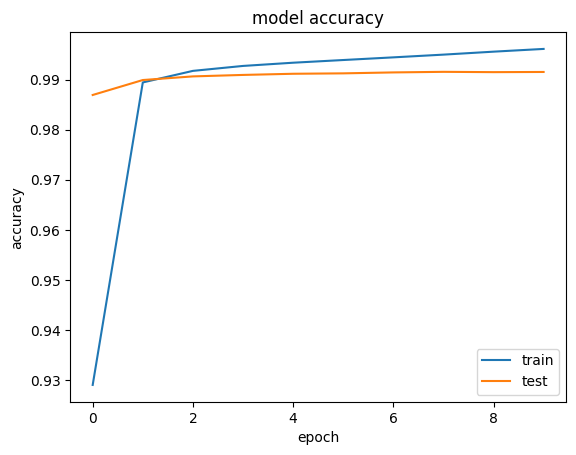

In [ ]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

4. GRU

Create model architecture

In [ ]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
# check summary of model
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_4 (TimeDi  (None, 100, 13)           845       
 stributed)                                                      
                                                                 
Total params: 17905817 (68.31 MB)
Trainable params: 17905817 (68.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 35s 82ms/step - loss: 0.2259 - acc: 0.9561 - val_loss: 0.0356 - val_acc: 0.9885
Epoch 2/10
408/408 [==============================] - 11s 28ms/step - loss: 0.0276 - acc: 0.9904 - val_loss: 0.0270 - val_acc: 0.9903
Epoch 3/10
408/408 [==============================] - 10s 24ms/step - loss: 0.0207 - acc: 0.9924 - val_loss: 0.0249 - val_acc: 0.9909
Epoch 4/10
408/408 [==============================] - 10s 25ms/step - loss: 0.0180 - acc: 0.9933 - val_loss: 0.0241 - val_acc: 0.9912
Epoch 5/10
408/408 [==============================] - 7s 16ms/step - loss: 0.0163 - acc: 0.9939 - val_loss: 0.0238 - val_acc: 0.9914
Epoch 6/10
408/408 [==============================] - 7s 16ms/step - loss: 0.0149 - acc: 0.9944 - val_loss: 0.0240 - val_acc: 0.9915
Epoch 7/10
408/408 [==============================] - 6s 16ms/step - loss: 0.0137 - acc: 0.9948 - val_loss: 0.0241 - val_acc: 0.9915
Epoch 8/10
408/408 [==============================] - 7s 18ms/ste

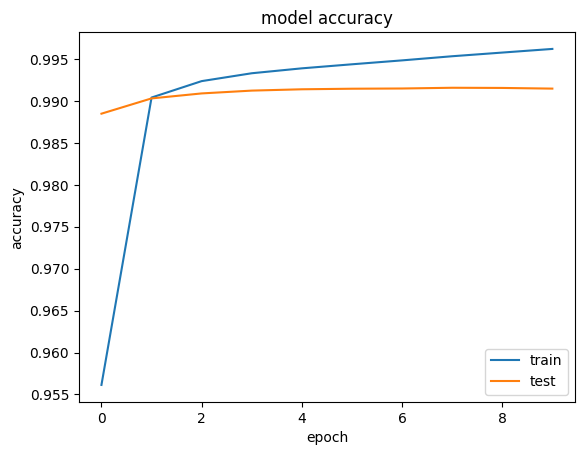

In [ ]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

4. Bidirectional LSTM

Create model architecture

In [ ]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          186880    
 al)                                                             
                                                                 
 time_distributed_5 (TimeDi  (None, 100, 13)           1677      
 stributed)                                                      
                                                                 
Total params: 18023257 (68.75 MB)
Trainable params: 18023257 (68.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 36s 76ms/step - loss: 0.2306 - acc: 0.9457 - val_loss: 0.0309 - val_acc: 0.9906
Epoch 2/10
408/408 [==============================] - 14s 35ms/step - loss: 0.0228 - acc: 0.9927 - val_loss: 0.0215 - val_acc: 0.9929
Epoch 3/10
408/408 [==============================] - 10s 25ms/step - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0193 - val_acc: 0.9934
Epoch 4/10
408/408 [==============================] - 10s 25ms/step - loss: 0.0125 - acc: 0.9958 - val_loss: 0.0186 - val_acc: 0.9937
Epoch 5/10
408/408 [==============================] - 9s 23ms/step - loss: 0.0103 - acc: 0.9966 - val_loss: 0.0182 - val_acc: 0.9940
Epoch 6/10
408/408 [==============================] - 9s 23ms/step - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0182 - val_acc: 0.9941
Epoch 7/10
408/408 [==============================] - 9s 23ms/step - loss: 0.0067 - acc: 0.9979 - val_loss: 0.0189 - val_acc: 0.9941
Epoch 8/10
408/408 [==============================] - 8s 21ms/ste

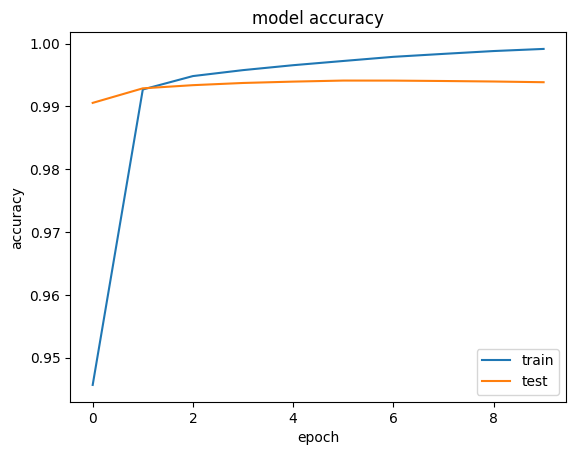

In [ ]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

5. Model evaluation

In [ ]:
loss, accuracy = rnn_model.evaluate(X_test,Y_test, verbose=1)
print('loss : {}, \nAccuracy : {}'.format(loss, accuracy))

339/339 [==============================] - 4s 13ms/step - loss: 0.0309 - acc: 0.9905
loss : 0.03089800477027893, 
Accuracy : 0.9905161261558533


In [ ]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 2s 4ms/step - loss: 0.0254 - acc: 0.9916
Loss: 0.025409849360585213,
Accuracy: 0.9915899038314819


In [ ]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 2s 5ms/step - loss: 0.0255 - acc: 0.9915
Loss: 0.02545086294412613,
Accuracy: 0.9914855360984802


In [ ]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 2s 6ms/step - loss: 0.0225 - acc: 0.9938
Loss: 0.022491931915283203,
Accuracy: 0.9937992691993713
